## Timeseries of globally-integrated energy flux from barotropic to baroclinic tides

In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

numpy version  :  1.26.0
pandas version :  2.1.1
xarray version :  2023.6.0


In [19]:
#sns.set_style('white')
#sns.set_context('paper', font_scale=3)
#sns.set_palette('hls', 6)
#sns.set_style('ticks')

In [20]:
dirstix = "/net2/rnd/dev/stixfonts/fonts/static_ttf"
import matplotlib.font_manager as font_manager
for font in font_manager.findSystemFonts(dirstix):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'STIX Two Text'

In [21]:
import os, sys
sys.path.append('../../')

In [22]:
from CM4X_metadata import *
exp_dict

{'CM4p25': {'hgrid': '/archive/Raphael.Dussin/datasets/OM4p25/c192_OM4_025_grid_No_mg_drag_v20160808_unpacked/ocean_hgrid.nc',
  'piControl-spinup': 'odiv-210',
  'piControl': 'odiv-230',
  'historical': 'odiv-231',
  'ssp585': 'odiv-232'},
 'CM4p125': {'hgrid': '/archive/Raphael.Dussin/datasets/OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc',
  'piControl': 'odiv-209',
  'historical': 'odiv-255',
  'ssp585': 'odiv-293'}}

In [23]:
import doralite
import gfdl_utils.core as gu

In [24]:
def load_dataset(exp_name):
    pp = doralite.dora_metadata(exp_name)['pathPP']
    ppname = gu.find_unique_variable(pp, "TKE_itidal")
    out = "ts"
    local = gu.get_local(pp, ppname, out)
    static = gu.open_static(pp, ppname)
    ds = gu.open_frompp(pp, ppname, out, local, time="*", add="TKE_itidal", dmget=True)
    offset_years = 1850-101 if "piControl" in pp else 0
    ds = ds.assign_coords({'year': ds.time.dt.year + offset_years})
    return xr.merge([ds, static])

In [26]:
cutoff_depth=2500

ds_dict = {}
for model, exps in exp_dict.items():
    ds_dict[model] = {}
    for exp, exp_name in exps.items():
        if exp=='hgrid': continue
        
        data_path = f"../../data/TKE_itidal_global_{model}_{exp}.nc"
        if True:#not(os.path.isfile(data_path)):
            ds = load_dataset(exp_name)
            ds['TKE_itidal_areaweighted'] = ds.TKE_itidal*ds.areacello
            ds['TKE_itidal_global'] = ds.TKE_itidal_areaweighted.sum(['xh', 'yh']).compute()*1e-12

            ncells = 8 if model=="CM4p25" else 16
            ds['deptho_smooth'] = ds.deptho.fillna(0.).rolling({"xh":ncells, "yh":ncells}).mean()

            ds['TKE_itidal_deep'] = (
                ds.TKE_itidal_areaweighted
                .where(ds.deptho_smooth > cutoff_depth)
            ).sum(["xh", "yh"]).compute()*1e-12
            ds['TKE_itidal_shallow'] = ds.TKE_itidal_global - ds.TKE_itidal_deep
            ds.drop_dims(['nv', 'xh', 'yh', 'xq', 'yq']).to_netcdf(data_path, mode="w")
        else:
            print(f"Loading existing processed data file for {model} {exp}.")
            ds = xr.open_dataset(data_path)
            
        ds_dict[model][exp] = ds

Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.


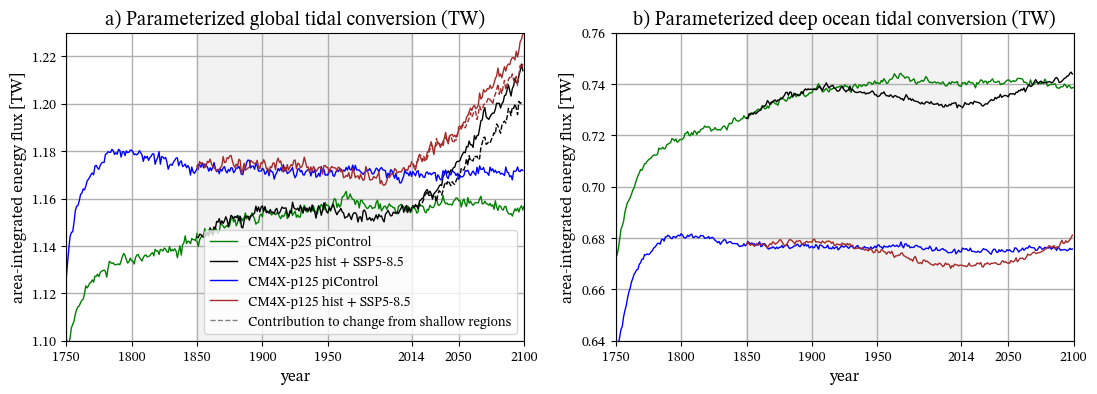

In [36]:
plot_dict = {
    "CM4p25":{
        "piControl-spinup":{"color":"green", "label":None},
        "piControl":{"color":"green", "label":"CM4X-p25 piControl"},
        "historical":{"color":"black", "label":"CM4X-p25 hist + SSP5-8.5"},
        "ssp585":{"color":"black", "label":None},
    },
    "CM4p125":{
        "piControl":{"color":"blue", "label":"CM4X-p125 piControl"},
        "historical":{"color":"brown", "label":"CM4X-p125 hist + SSP5-8.5"},
        "ssp585":{"color":"brown", "label":None},
    }
}
lw = 1.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(13,4.0))

ax = axes[0]
for model, exps in ds_dict.items():
    for exp, ds in exps.items():
        
        if "spinup" in exp:
            da = ds.TKE_itidal_global.swap_dims({'time':'year'}).sel(year=slice(1750, 1850))
        else:
            da = ds.TKE_itidal_global
        da.plot.line(ax=ax, x='year', lw=lw, **plot_dict[model][exp])

    shallow_change = (
        exps['ssp585'].swap_dims({'time':'year'}).TKE_itidal_shallow
        - exps['piControl'].swap_dims({'time':'year'}).TKE_itidal_shallow
    )
    shallow_change -= shallow_change.sel(year=2015)
    (
        shallow_change
        + exps['ssp585'].swap_dims({'time':'year'}).TKE_itidal_global.sel(year=2015)
    ).plot(ax=ax, x='year', ls="--", color=plot_dict[model]["ssp585"]['color'], lw=lw)
ax.plot([], [], ls="--", color="grey", lw=1, label="Contribution to change from shallow regions")

ax = axes[1]
for model, exps in ds_dict.items():
    for exp, ds in exps.items():
        
        if "spinup" in exp:
            da = ds.TKE_itidal_deep.swap_dims({'time':'year'}).sel(year=slice(1750, 1850))
        else:
            da = ds.TKE_itidal_deep
        da.plot.line(ax=ax, x='year', lw=lw, color=plot_dict[model][exp]["color"])
    
for ax in axes:
    ax.set_ylabel('area-integrated energy flux [TW]',fontsize=12)
    ax.set_xlabel('year',fontsize=12)
    ax.grid(linewidth=1)
    ax.set_xlim(1750, 2100)
    ax.set_xticks([1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])

    yrs = ds_dict['CM4p125']['piControl'].year.values
    ax.fill_between(
        yrs, 0, 2, where=(yrs >= 1850) & (yrs <= 2014),
        interpolate=True, color='gray', alpha=0.1
    )

axes[0].legend(loc='lower right')
axes[0].set_ylim(1.10,1.23)
axes[0].set_title('a) Parameterized global tidal conversion (TW)',fontsize=14);
axes[1].set_ylim(0.64, 0.76)
axes[1].set_title('b) Parameterized deep ocean tidal conversion (TW)',fontsize=14);
fig.savefig('../../figures/tidal_conversion.jpg', bbox_inches='tight', dpi=400, format='jpeg')